## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [1]:
#doing my imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# TODO - your code!
#reading in the congressional voting data 
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
header_columns = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'] 
house = pd.read_csv(url, header=None, names=header_columns, na_values='?')
house.sample(5)

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
350,democrat,n,y,n,n,n,y,y,n,y,n,y,n,n,n,y,y
264,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,NaN
81,democrat,y,n,y,n,n,n,y,y,NaN,y,y,y,n,y,n,y
360,democrat,y,n,y,n,n,y,y,y,y,y,n,n,y,n,n,y
342,democrat,n,y,y,n,y,NaN,y,n,n,y,y,n,y,n,y,y


In [3]:
#recoding the data to binomial answer format 

house = house.replace({'n':0, 'y':1})
house.sample(5) 

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
401,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
26,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
400,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,NaN
60,democrat,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
146,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [5]:
#splitting the data into repubs and dems 
rep= house[house['party'] =='republican']
dem = house[house['party'] =='democrat']
print(rep.sample(5))
dem.sample(5)

          party  handicapped-infants  ...  duty-free  south-africa
409  republican                  0.0  ...        0.0           0.0
136  republican                  0.0  ...        0.0           1.0
300  republican                  0.0  ...        0.0           1.0
364  republican                  1.0  ...        0.0           1.0
7    republican                  0.0  ...        NaN           1.0

[5 rows x 17 columns]


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
255,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
194,democrat,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
168,democrat,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
104,democrat,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,1.0,1.0,0.0,NaN
42,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
rep.dropna(inplace=True)
dem.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#finding the mean of the republicans votes on immigration 
rep['immigration'].mean()

0.5740740740740741

In [10]:
#finding the confidence interval around this mean
conf_int = stats.t.interval(.95, 
                            rep.shape[0], 
                            loc = rep['immigration'].mean(), 
                            scale= (np.std(rep['immigration'], ddof=1))/rep.shape[0] **.5
                            )
conf_int

(0.4793193702923455, 0.6688287778558026)

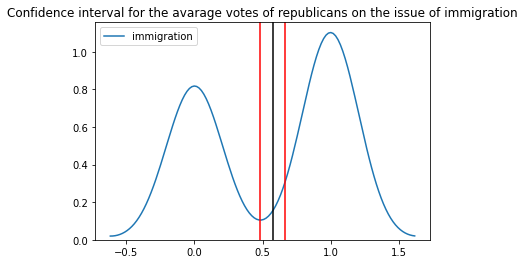

In [17]:
#graphically representing the confidence intervals 
sns.kdeplot(rep['immigration'])
plt.axvline(x=conf_int[0], color='red')
plt.axvline(x=conf_int[1], color='red')
plt.axvline(x=rep['immigration'].mean(), color='k')
plt.title('Confidence interval for the avarage votes of republicans on the issue of immigration');

###The confidence interval in this particular data tells us that we can be 95% sure that the mean of the population for republicans votes on the immigration issue in question will be between .48 and .67 

Breaking this down further we can say that we can be 95% sure that between 48% and 67% of republicans in the population voted yes on the issue of immigration in question in the data

In [20]:
#Reading in the data for the chi squared test 
column_head= ['buying', 'maint', 'doors', 'persons', 'lu_boot', 'saftey', 'class']
source= 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
car = pd.read_csv(source, header=None, names=column_head)

car.sample(5)

,buying,maint,doors,persons,lu_boot,saftey,class
28,vhigh,vhigh,3,2,small,med,unacc
1607,low,med,5more,4,med,high,vgood
481,high,vhigh,3,more,med,med,unacc
792,high,low,3,4,small,low,unacc
1505,low,high,5more,more,small,high,acc


In [22]:
#making a crosstab 
xtab = pd.crosstab(car['saftey'], car['class'], margins=True)
xtab

class,acc,good,unacc,vgood,All
saftey,,,,,
high,204,30,277,65,576
low,0,0,576,0,576
med,180,39,357,0,576
All,384,69,1210,65,1728


In [23]:
#Getting to the calculation expected = row total * column total / total observations 
#finding the row sums 
row_sums = xtab.iloc[0:3, 4].values
row_sums

array([576, 576, 576])

In [26]:
#column sums
col_sums = xtab.iloc[3, 0:4].values
col_sums

array([ 384,   69, 1210,   65])

In [27]:
#getting the total data 
total = xtab.loc['All', 'All'] 
total

1728

In [28]:
#finding the expected value 
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
pd.DataFrame(expected)

,0,1,2,3
0,128.0,23.0,403.333333,21.666667
1,128.0,23.0,403.333333,21.666667
2,128.0,23.0,403.333333,21.666667


In [29]:
#finding observed values 
observed = pd.crosstab(car['saftey'], car['class']).values
pd.DataFrame(observed)

,0,1,2,3
0,204,30,277,65
1,0,0,576,0
2,180,39,357,0


In [31]:
#running the chi squared with numpy 
chi_squared = ((observed - expected)**2/(expected)).sum()
print('Chi_squared =', chi_squared)

Chi_squared = 479.3224398131512


In [33]:
#running chi squared with scipy 
chi2 = stats.chi2_contingency(observed)
chi2

(479.3224398131512,
 2.389155399044034e-100,
 6,
 array([[128.        ,  23.        , 403.33333333,  21.66666667],
        [128.        ,  23.        , 403.33333333,  21.66666667],
        [128.        ,  23.        , 403.33333333,  21.66666667]]))

In [38]:
#what each means 
print('stat:', chi2[0])
print('pvalue:', chi2[1])
print('dof:', chi2[2])
print('expected:')
pd.DataFrame(chi2[3])

stat: 479.3224398131512
pvalue: 2.389155399044034e-100
dof: 6
expected:


,0,1,2,3
0,128.0,23.0,403.333333,21.666667
1,128.0,23.0,403.333333,21.666667
2,128.0,23.0,403.333333,21.666667


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [40]:
#reading in data 
url1 = 'https://query.data.world/s/bhpbqbe7hhbkljl2rj5ndi7blx3yvs'
mental_health = pd.read_csv(url1)

mental_health.sample(5)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
850,2014-08-28 16:57:49,42,Male,United States,WI,No,No,Yes,Sometimes,1-5,Yes,Yes,No,Yes,No,No,Don't know,Somewhat easy,Maybe,No,No,No,No,Maybe,Don't know,No,NaN
808,2014-08-28 13:57:01,27,Male,United States,IN,No,No,No,NaN,26-100,Yes,Yes,Don't know,Not sure,No,Don't know,Don't know,Very easy,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN
466,2014-08-27 16:06:46,57,M,United States,CA,No,Yes,Yes,Rarely,More than 1000,No,Yes,Yes,Yes,No,No,Don't know,Don't know,Maybe,No,Some of them,Yes,No,Maybe,No,No,NaN
606,2014-08-27 23:10:16,50,Male,United States,WY,No,No,No,Sometimes,1-5,Yes,Yes,Don't know,No,No,Don't know,Don't know,Don't know,Yes,Maybe,Some of them,Some of them,No,Maybe,Don't know,No,I work for a very small firm that doesn't real...
34,2014-08-27 11:40:51,40,female,United States,WI,No,No,Yes,Sometimes,1-5,No,Yes,Yes,Yes,No,No,Don't know,Don't know,Maybe,No,Some of them,No,No,Maybe,Yes,No,NaN


In [71]:
mental_health.shape

(1259, 27)

In [50]:
mental_health['Gender'].value_counts()

Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Male                                                3
Woman                                               3
Female                                              2
Cis Male                                            2
Female (trans)                                      2
Man                                                 2
Trans woman                                         1
Neuter                                              1
msle                                                1
Malr                        

In [55]:
list(mental_health.columns)

['Timestamp',
 'Age',
 'Gender',
 'Country',
 'state',
 'self_employed',
 'family_history',
 'treatment',
 'work_interfere',
 'no_employees',
 'remote_work',
 'tech_company',
 'benefits',
 'care_options',
 'wellness_program',
 'seek_help',
 'anonymity',
 'leave',
 'mental_health_consequence',
 'phys_health_consequence',
 'coworkers',
 'supervisor',
 'mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical',
 'obs_consequence',
 'comments']

In [67]:
# creating a crosstab to explore gender vs seeking help
xtab1 = pd.crosstab(mental_health['self_employed'],
                    mental_health['seek_help'],
                    margins=True,
                    normalize='index')
xtab1

seek_help,Don't know,No,Yes
self_employed,,,
No,0.302283,0.491324,0.206393
Yes,0.164384,0.678082,0.157534
All,0.286060,0.513296,0.200645


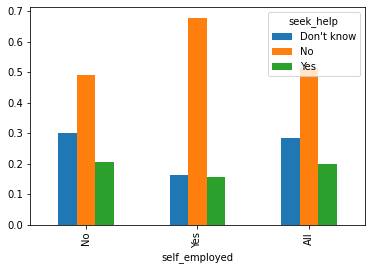

In [65]:
#plotting the data
xtab1.plot(kind='bar');

In [69]:
#running a chi2 on this data 
observed1=pd.crosstab(mental_health['self_employed'], mental_health['seek_help']).values
observed1

array([[331, 538, 226],
       [ 24,  99,  23]])

In [70]:
#Null hypothesis: There is no significant difference between indiviuals who are self employed and those who are not in seeking help for mental health
#Alt hypothesis: Those who are not self employed are more likely to seek help for mental health issues 
stats.chi2_contingency(observed1)

(18.85000436856246,
 8.068142486955067e-05,
 2,
 array([[313.23529412, 562.05882353, 219.70588235],
        [ 41.76470588,  74.94117647,  29.29411765]]))

In [0]:
# the t stat is 18.85 and the p value is 8.07 e-05 so we reject the null hypothesis due to a p value of less than .5 

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)